In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


### The Mandelbrot set
The Mandelbrot set is a two-dimensional set that is defined in the complex plane as the complex numbers $c$ for which the function $f_c(z) = z^2 + c $ does not diverge to infinity when iterated starting at $z=0$.

Interesting properties:
- A point c belongs to the Mandelbrot set iff $|z| \leq 2$ for all $n \geq 0$

### Representing complex numbers

To represent the complex numbers, I will use an array of two float, where the first element represents the real part and the second element the imaginary part.

In [2]:
def square(x):
    result = [0, 0]

    result[0] = x[0]**2 - x[1]**2
    result[1] = 2 * x[0] * x[1]

    return result


def compute(c, z):
    """Compute z^2 + c"""
    z_square = square(z)
    return [c[0] + z_square[0] , c[1] + z_square[1]]


def isInMandelbrotSet(c, z=[0, 0], max_iter=1000, n=0) -> bool:
    if z[0]**2 + z[1]**2 > 4:
        return False
    
    if n==max_iter:
        return True

    return isInMandelbrotSet(c, compute(c, z), max_iter, n+1)


In [3]:
print(f"Is [-1,0] in the set?: {isInMandelbrotSet([-1, 0])}")  # should be true
print(f"Is [1,0] in the set?: {isInMandelbrotSet([1, 0])}")  # should be false

Is [-1,0] in the set?: True
Is [1,0] in the set?: False


### Creating a dataset

In [4]:
# Define the range for the real and imaginary parts
real_range = np.linspace(-2, 1, 50)
imag_range = np.linspace(-1.5, 1.5, 50)

data = []
for a in real_range:
    for b in imag_range:
        c = [a, b]
        is_in_set = isInMandelbrotSet(c)
        data.append({
            'real': a,
            'imag': b,
            'in_mandelbrot_set': is_in_set
        })

df = pd.DataFrame(data)

In [5]:
df

,real,imag,in_mandelbrot_set
0,-2.0,-1.500000,False
1,-2.0,-1.438776,False
2,-2.0,-1.377551,False
3,-2.0,-1.316327,False
4,-2.0,-1.255102,False
...,...,...,...
2495,1.0,1.255102,False
2496,1.0,1.316327,False
2497,1.0,1.377551,False
2498,1.0,1.438776,False


As we can see, the dataset is heavily imbalanced. It is very important to remember this, because it will affect the way we measure the performance pf the model and the way we split the dataset.

In [6]:
df['in_mandelbrot_set'].value_counts()

in_mandelbrot_set
False    2094
True      406
Name: count, dtype: int64

In [7]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["in_mandelbrot_set"])
y = df["in_mandelbrot_set"]

# Using stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True
)

# Create validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, stratify=y_train, random_state=42
)


### Neural Network

In [8]:
class NeuralNet(nn.Module):
    def __init__(self, num_hidden_layers=3):
        super().__init__()
        
        layers = [
            nn.Linear(2, 32),
            nn.ReLU(),
        ]

        for _ in range(num_hidden_layers):
            layers.append(
                nn.Linear(32, 32)
            )
            layers.append(
                nn.ReLU()
            )
        
        # Output
        layers.append(
            nn.Linear(32, 1)
        )
        self.sigmoid_layer = nn.Sigmoid()
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = self.network(x)
        return self.sigmoid_layer(x)

### Training Loop

In [9]:
from torch.utils.data import TensorDataset, DataLoader

def train(model, X_train, y_train, X_val, y_val, num_epoch=20, batch_size=16, lr=0.0001, criterion=nn.BCELoss()):

    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1) # Convert target to float and unsqueeze for BCEWithLogitsLoss

    # Create a TensorDataset and DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    # Convert data to PyTorch tensors
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1) # Convert target to float and unsqueeze for BCEWithLogitsLoss

    # Create a TensorDataset and DataLoader
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epoch):
        model.train() # Set the model to training mode
        train_loss = 0
        for batch_X, batch_y in train_loader:
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * batch_X.size(0)
        
        model.eval() # Set the model to training mode
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

                val_loss += loss.item() * batch_X.size(0)
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)
        
        # Store losses
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")


    # Plot the learning curves
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="Training loss")
    plt.plot(val_losses, label="Validation loss")
    plt.title("Learning Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return model

### Testing Loop

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from torch.utils.data import TensorDataset, DataLoader

def test(model, X_test, y_test):
    # Convert data to Pytorch tensors
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

    # Evaluation mode
    model.eval() 

    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
        
        # Convert probabilities to binary predictions (0 or 1)
        y_pred = (y_pred_tensor > 0.5).float()

        # Calculate metrics
        accuracy = accuracy_score(y_test_tensor.numpy(), y_pred.numpy())
        print(f"Test Accuracy: {accuracy:.4f}\n")
        
        print("Classification Report:")
        print(classification_report(y_test_tensor.numpy(), y_pred.numpy()))
        
        print("Confusion Matrix:")
        print(confusion_matrix(y_test_tensor.numpy(), y_pred.numpy()))

        f1 = f1_score(y_test_tensor.numpy(), y_pred.numpy(), pos_label=1)
        tn, fp, fn, tp = confusion_matrix(y_test_tensor.numpy(), y_pred.numpy()).ravel()

        report = {
            "accuracy": accuracy,
            "f1_score_positive": f1,
            "true_positives": tp,
            "false_positives": fp,
            "true_negatives": tn,
            "false_negatives": fn
        }
        return report

### Choosing Model

We will use the validation set to test the different models and choose which one we want to use.

Training model: 1_hidden_layer
Epoch: 1, Train Loss: 0.708346113317153, Val Loss: 0.6741683316230774
Epoch: 2, Train Loss: 0.6366901613684262, Val Loss: 0.5977257283528646
Epoch: 3, Train Loss: 0.5568070847847882, Val Loss: 0.5192946259180705
Epoch: 4, Train Loss: 0.48274046533248005, Val Loss: 0.45584290663401283
Epoch: 5, Train Loss: 0.4305696018303142, Val Loss: 0.4171098168690999
Epoch: 6, Train Loss: 0.4004001656700583, Val Loss: 0.39570733308792116
Epoch: 7, Train Loss: 0.3832945585250854, Val Loss: 0.3830734825134277
Epoch: 8, Train Loss: 0.37228802169070524, Val Loss: 0.3741066312789917
Epoch: 9, Train Loss: 0.36373359154252444, Val Loss: 0.3664038666089376
Epoch: 10, Train Loss: 0.3558984100818634, Val Loss: 0.35890212615331013
Epoch: 11, Train Loss: 0.3481466084017473, Val Loss: 0.35141883850097655
Epoch: 12, Train Loss: 0.3403449109722586, Val Loss: 0.34376790444056193
Epoch: 13, Train Loss: 0.33236104824963736, Val Loss: 0.3359519712130229
Epoch: 14, Train Loss: 0.324287929

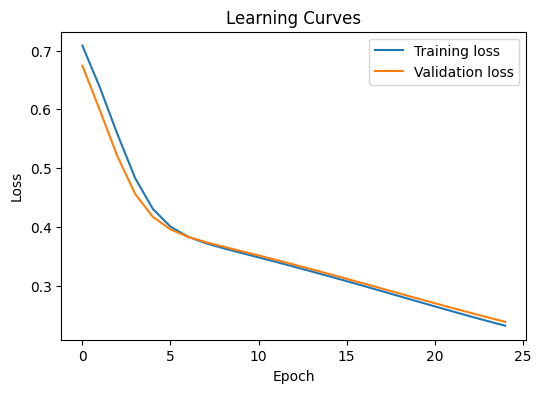

Test Accuracy: 0.8780

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93       419
         1.0       1.00      0.25      0.40        81

    accuracy                           0.88       500
   macro avg       0.94      0.62      0.66       500
weighted avg       0.89      0.88      0.85       500

Confusion Matrix:
[[419   0]
 [ 61  20]]
Training model: 3_hidden_layers
Epoch: 1, Train Loss: 0.759888131758746, Val Loss: 0.7407363025347392
Epoch: 2, Train Loss: 0.7244348551245297, Val Loss: 0.7073450271288554
Epoch: 3, Train Loss: 0.6831275165782256, Val Loss: 0.6476244775454203
Epoch: 4, Train Loss: 0.5872950994968414, Val Loss: 0.5163052678108215
Epoch: 5, Train Loss: 0.44905280421761906, Val Loss: 0.40151362816492714
Epoch: 6, Train Loss: 0.3871098485063104, Val Loss: 0.3805714702606201
Epoch: 7, Train Loss: 0.3726563722596449, Val Loss: 0.3693402043978373
Epoch: 8, Train Loss: 0.36089006273185503, Val Loss: 0.3

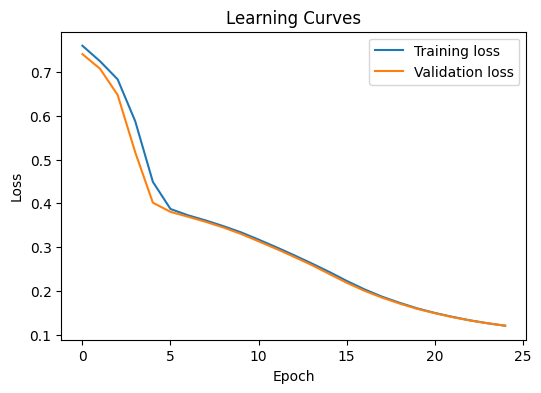

Test Accuracy: 0.9500

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       419
         1.0       0.87      0.81      0.84        81

    accuracy                           0.95       500
   macro avg       0.92      0.90      0.91       500
weighted avg       0.95      0.95      0.95       500

Confusion Matrix:
[[409  10]
 [ 15  66]]
Training model: 5_hidden_layers
Epoch: 1, Train Loss: 0.6441984643655665, Val Loss: 0.6338462694485982
Epoch: 2, Train Loss: 0.6209395877052756, Val Loss: 0.6040591621398925
Epoch: 3, Train Loss: 0.559103610235102, Val Loss: 0.4889954439798991
Epoch: 4, Train Loss: 0.41965664968771094, Val Loss: 0.38817118167877196
Epoch: 5, Train Loss: 0.3728799014231738, Val Loss: 0.3674910449981689
Epoch: 6, Train Loss: 0.35174719761399664, Val Loss: 0.3456283410390218
Epoch: 7, Train Loss: 0.32750556339235865, Val Loss: 0.3209164861838023
Epoch: 8, Train Loss: 0.3004655975278686, Val Loss: 0.

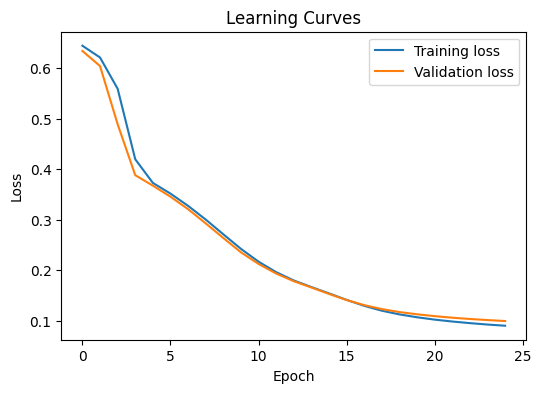

Test Accuracy: 0.9540

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       419
         1.0       0.84      0.89      0.86        81

    accuracy                           0.95       500
   macro avg       0.91      0.93      0.92       500
weighted avg       0.96      0.95      0.95       500

Confusion Matrix:
[[405  14]
 [  9  72]]


In [20]:
model_configs = {
    "1_hidden_layer": NeuralNet(num_hidden_layers=1),
    "3_hidden_layers": NeuralNet(num_hidden_layers=3),
    "5_hidden_layers": NeuralNet(num_hidden_layers=5)
}

results = {}

for name, model in model_configs.items():
    print(f"Training model: {name}")
    
    # Train the model
    trained_model = train(model, X_train, y_train, X_val, y_val, num_epoch=25)
    
    # Test the model and store the returned metrics
    results[name] = test(trained_model, X_test, y_test)